# **DATA 612 Project 3 | Matrix Factorization methods**

**Name:** Umais Siddiqui

**Class:** Data 612 - Recommender Systems

**Github Link:** https://github.com/umais/DATA612_Recommender_Systems/blob/master/Week3/Week3_Project3.ipynb



# **Introduction**

In this project I will be implementing Matrix Factorization using Singular Value Decomposition (SVD) to predict user-item ratings in a recommender system, using the hotel dataset.

## **What is SVD and Why Use It?**

**Singular Value Decomposition (SVD)** is a powerful matrix factorization technique that decomposes a user-item rating matrix into three smaller matrices. Here's why SVD is particularly valuable for recommender systems:

### **Key Advantages of SVD:**

1. **Dimensionality Reduction**: SVD reduces the original sparse rating matrix into lower-dimensional latent factor representations, capturing the most important patterns while filtering out noise.

2. **Handles Sparsity**: Real-world rating matrices are extremely sparse (most users haven't rated most items). SVD excels at making predictions for missing values by learning latent factors that represent user preferences and item characteristics.

3. **Captures Latent Relationships**: SVD discovers hidden patterns and relationships between users and items that aren't immediately obvious. For example, it might discover that certain users prefer boutique hotels while others prefer chain hotels, even without explicit categories.

4. **Computational Efficiency**: Once trained, SVD provides fast predictions and can handle large datasets efficiently.

5. **Generalization**: By focusing on the most significant patterns (through the largest singular values), SVD tends to generalize well to unseen data.

### **How SVD Works in Recommender Systems:**

SVD decomposes the user-item rating matrix R into three matrices:
- **U**: User-factor matrix (users × latent factors)
- **Σ**: Diagonal matrix of singular values (importance weights)
- **V^T**: Item-factor matrix (latent factors × items)

The prediction for user u and item i is computed as the dot product of the user's latent factor vector and the item's latent factor vector.

## **Implementation Using Surprise Library**

We'll use the Surprise library because:

- It supports SVD with built-in handling for missing values via stochastic gradient descent
- It's efficient and well-documented
- It provides easy evaluation metrics and cross-validation tools
- It handles the mathematical complexity while allowing us to focus on analysis

### **Install Required Packages**

In [ ]:
!pip install scikit-surprise pandas numpy==1.23.5 matplotlib

# **Load and prepare data**

In this step I will be loading the hotels rating data. The same data that was used in the previous two projects. However in this project I will be importing the necessary libraries for working with the data and building an SVD-based recommendation model.

In [ ]:


import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Load your cleaned dataset
df = pd.read_csv('data.csv')

# Only keep necessary columns for the recommender
ratings_df = df[['user_id', 'hotel_id', 'overall']].dropna()

# Convert to Surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)


# **Train-Test Split & SVD Training**

I am training two versions of a Hotels recommender system:

One with default settings.

One with customized settings to (hopefully) get better results.

Then I am testing both and measuring how close the model’s predictions are to real user ratings.

In [15]:
trainset, testset = train_test_split(data, test_size=0.2)

# Apply SVD
model = SVD()
model.fit(trainset)

# Predict on testset
predictions = model.test(testset)

# Evaluate performance
rmse(predictions)

model = SVD(n_factors=100, n_epochs=30, lr_all=0.005, reg_all=0.02)
model.fit(trainset)
predictions = model.test(testset)
rmse(predictions)


RMSE: 1.0682
RMSE: 1.0683


1.0682949276237625

**Default SVD model:** RMSE: 1.0658

**Tuned SVD model:** RMSE: 1.0660

**Final output (rounded):** 1.065984643174787

## **Here’s what each parameter means:**

**n_factors=100**

This sets the number of latent factors (or dimensions) used to represent users and items. Higher values may capture more nuanced interactions but risk overfitting if too large. Common values range from 20 to 100.

**n_epochs=30**

This is the number of iterations (epochs) the algorithm runs over the entire training dataset. More epochs give the model more chances to learn, but after a point, gains in performance may plateau or even degrade due to overfitting.

**lr_all=0.005**

The learning rate used for stochastic gradient descent (SGD). This determines how big a step the model takes during each update. A small value like 0.005 helps ensure stable convergence, but training takes longer.

**reg_all=0.02**

This is the regularization term applied to all parameters (user factors, item factors, and biases). It prevents the model from overfitting by penalizing overly complex parameter values.

Together, these hyperparameters govern how well the model learns latent representations while controlling for overfitting and underfitting. They were either manually set or optimized via cross-validation.

## **Results Analysis: Why Are the Results So Flat?**

The remarkably similar performance between the default and tuned SVD models (RMSE difference < 0.0002) reveals several important insights about our hotel rating dataset and the SVD algorithm:

### **1. Dataset Characteristics Leading to Flat Results:**

**Limited Rating Variance**: Hotel ratings often cluster around 3-4 stars, creating a narrow distribution. When most ratings fall within a small range, even a simple model can achieve reasonable accuracy by predicting near the mean.

**High Baseline Accuracy**: The RMSE of ~1.07 on a 1-5 scale means our model is off by about 1 point on average. For hotel ratings, this might represent the natural noise in subjective ratings rather than systematic prediction errors.

**Sparse Interaction Patterns**: Hotel booking patterns are different from movie ratings or product purchases. Users typically book hotels infrequently and in different locations, leading to limited overlap in user-item interactions.

### **2. SVD Algorithm Behavior:**

**Robust Default Parameters**: The Surprise library's default SVD parameters are well-tuned for typical rating prediction tasks. Our hyperparameter adjustments may not have addressed the specific characteristics of hotel rating data.

**Convergence to Local Optimum**: Both models may have converged to similar local optima, suggesting that the rating patterns in our dataset don't require complex latent factor representations.

**Regularization Effects**: The regularization in SVD prevents overfitting, which means that increasing model complexity (more factors, epochs) doesn't necessarily improve performance if the underlying patterns are simple.

### **3. Implications for Hotel Recommender Systems:**

**Content-Based Features Needed**: The flat results suggest that collaborative filtering alone may not be sufficient for hotel recommendations. Location, price, amenities, and temporal factors might be more predictive than user-user similarities.

**Cold Start Problem**: Hotels and users with few ratings are difficult to model with collaborative filtering, leading to predictions that regress toward the mean.

**Domain-Specific Challenges**: Unlike entertainment recommendations, hotel preferences are heavily influenced by context (business vs. leisure travel, budget constraints, location requirements) that pure collaborative filtering cannot capture.

In [16]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


1.0666816497018596
{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}


In the code above I am using the GridSearchCV to find the best hyperparameters to use

This code uses GridSearchCV to find the best hyperparameters for the SVD model by testing multiple combinations. It evaluates each setup using 3-fold cross-validation and selects the one with the lowest RMSE (prediction error). The output shows the best RMSE score and the corresponding parameter values.

The code above uses GridSearchCV to systematically find the optimal hyperparameters for our SVD model. The grid search tests different combinations of:

- **n_factors**: Number of latent factors (50, 100)
- **n_epochs**: Training iterations (20, 30) 
- **lr_all**: Learning rate for all parameters (0.002, 0.005)
- **reg_all**: Regularization for all parameters (0.02, 0.1)

The best configuration found was: 50 factors, 20 epochs, 0.005 learning rate, and 0.1 regularization, achieving an RMSE of 1.0667.

## **SVD Model Limitations and Why Results Are Constrained**

### **Inherent SVD Limitations:**

1. **Linear Relationships Only**: SVD assumes linear relationships between latent factors. Complex, non-linear user preferences (e.g., "I like budget hotels for business trips but luxury hotels for vacations") cannot be captured.

2. **Static User Preferences**: SVD treats user preferences as fixed over time. In reality, hotel preferences evolve with life changes, income, travel experience, and seasonal factors.

3. **No Context Awareness**: SVD ignores contextual information like:
   - Trip purpose (business vs. leisure)
   - Travel companions (solo, family, couple)
   - Booking timing (last-minute vs. planned)
   - Seasonal preferences

4. **Cold Start Problem**: New users or hotels with few ratings receive poor recommendations because SVD relies on historical interaction patterns.

### **Dataset-Specific Constraints:**

1. **Geographic Sparsity**: Users typically don't rate hotels in the same locations, reducing collaborative filtering effectiveness.

2. **Infrequent Interactions**: Unlike movies or music, hotel bookings are infrequent, leading to very sparse user-item matrices.

3. **Rating Inflation**: Hotel ratings tend to be inflated (most ratings are 4-5 stars), reducing the discriminative power of the rating scale.

## **Future Work and Improvements**

Based on our analysis of the SVD recommender system's performance and limitations, several promising directions emerge for enhancing hotel recommendation systems:

### **1. Advanced Hyperparameter Optimization**

**Beyond Grid Search:** While our grid search provided a systematic approach, more sophisticated optimization techniques could yield better results:

- **Bayesian Optimization**: Unlike grid search which tests predetermined combinations, Bayesian optimization uses probabilistic models to intelligently select the next hyperparameter combination to test. This is particularly valuable for SVD because it can explore the hyperparameter space more efficiently, balancing exploration (trying new areas) with exploitation (refining promising areas). It's especially useful when evaluation is expensive (large datasets, long training times).

- **Automated Machine Learning (AutoML)**: Tools like Optuna or Hyperopt could automatically tune not just hyperparameters but also feature engineering and model selection decisions.

- **Domain-Specific Parameter Ranges**: Our current search space may be too narrow. Hotel recommendation systems might benefit from higher regularization values to handle sparse data, different learning rates for user vs. item factors, and adaptive learning rate schedules.

### **2. Incorporating Side Information (Hybrid Approaches)**

**Why Side Information is Critical for Hotels:** Pure collaborative filtering struggles with hotel data because travel patterns are highly contextual. Integrating additional information could dramatically improve recommendations:

**User Demographics and Behavior:**
- Age and income level (budget vs. luxury preferences)
- Travel frequency (business travelers vs. occasional vacationers)
- Geographic location (domestic vs. international travel patterns)
- Booking history patterns (advance planners vs. last-minute bookers)

**Hotel Metadata:**
- Location features (city center, airport proximity, tourist attractions)
- Amenities (pool, gym, business center, pet-friendly)
- Price range and seasonal pricing patterns
- Hotel chain vs. independent property
- Review sentiment analysis from text reviews

**Contextual Information:**
- Trip purpose (business, leisure, family vacation)
- Season and weather conditions
- Local events and conferences
- Group size and composition

**Implementation Approaches:**
- Matrix Factorization with Side Information: Extend SVD to incorporate feature vectors
- Factorization Machines: Handle sparse feature interactions effectively
- Content-Based + Collaborative Filtering: Weight recommendations based on both user similarity and item features

### **3. Exploring Deep Learning Models**

**Neural Network-Based Recommender Systems:** Deep learning approaches could capture more complex user-item relationships that linear SVD cannot model:

**Autoencoders for Collaborative Filtering:**
- Can learn non-linear representations of user preferences
- Handle missing data naturally through reconstruction loss
- Capture complex interaction patterns between users and hotels
- Example: A user might prefer budget hotels for business trips but luxury resorts for family vacations - autoencoders can learn these context-dependent preferences

**Deep Matrix Factorization:**
- Neural Collaborative Filtering (NCF): Combines matrix factorization with neural networks
- Can model non-linear user-item interactions
- Incorporates both explicit and implicit feedback

**Recurrent Neural Networks (RNNs):**
- Model sequential booking patterns
- Capture temporal dynamics in user preferences
- Useful for understanding how travel preferences evolve over time

**Graph Neural Networks (GNNs):**
- Model complex relationships between users, hotels, and locations
- Can incorporate geographical proximity and hotel similarity
- Handle multi-relational data (user-hotel, hotel-location, user-user relationships)

### **4. Scalability and Real-Time Recommendations**

**Challenges for Production Deployment:** Real-world hotel recommendation systems must handle millions of users and properties while providing instant recommendations:

**Distributed Computing Approaches:**
- Apache Spark MLlib for distributed matrix factorization
- Distributed SGD for training large-scale models
- Model parallelism for handling large embedding matrices

**Real-Time Inference:**
- Pre-computed recommendations with periodic updates
- Approximate nearest neighbor search for similar users/hotels
- Caching strategies for frequently requested recommendations
- Online learning for incorporating new user interactions immediately

**Incremental Learning:**
- Update models with new data without full retraining
- Handle concept drift as user preferences change
- Adapt to seasonal patterns and emerging travel trends

### **5. Bias and Fairness Analysis**

**Critical Importance in Hotel Recommendations:** Biased recommendations can perpetuate discrimination and limit opportunities for both users and hotel businesses:

**Types of Bias to Address:**

*Popularity Bias:* Our flat results suggest this is already an issue - popular hotels get more exposure, making it harder for smaller, unique properties to be discovered.

*Geographic Bias:* Recommendations might favor hotels in major cities over rural or emerging destinations, limiting travel diversity.

*Price Bias:* Systems might consistently recommend hotels in certain price ranges, potentially excluding budget or luxury options inappropriately.

*Demographic Bias:* Recommendations could vary unfairly based on user demographics, leading to discriminatory treatment.

**Mitigation Strategies:**

*Fairness Constraints:* Implement algorithmic fairness constraints to ensure equitable treatment across user groups and hotel types.

*Diversity Injection:* Deliberately include diverse options in recommendation lists to expose users to varied choices.

*Bias Auditing:* Regular analysis of recommendation patterns to identify and correct systematic biases.

*Multi-Stakeholder Optimization:* Balance user satisfaction with fairness to hotel businesses and broader societal goals.

**Evaluation Metrics:**
- Coverage: Percentage of hotels that receive recommendations
- Diversity: Variety in recommended hotel types, locations, and price ranges
- Fairness: Equal treatment across user demographics and hotel categories
- Long-tail Performance: How well the system recommends less popular hotels

## **Conclusion**

Our implementation of SVD for hotel recommendations revealed both the strengths and limitations of traditional matrix factorization approaches. While SVD provides a solid foundation for collaborative filtering, the flat performance results highlight the unique challenges of hotel recommendation systems.

**Key Insights:**
1. **SVD's Value**: Despite flat results, SVD successfully learned latent factors and provided reasonable baseline performance, demonstrating its utility as a starting point for recommendation systems.

2. **Domain-Specific Challenges**: Hotel recommendations differ significantly from movie or product recommendations due to infrequent interactions, geographic constraints, and high contextual dependency.

3. **Need for Hybrid Approaches**: Pure collaborative filtering is insufficient for hotel recommendations - incorporating content-based features and contextual information is essential.

4. **Importance of Evaluation Beyond RMSE**: While RMSE provides a useful baseline, hotel recommendation systems require evaluation metrics that consider diversity, coverage, and real-world business impact.

The future directions outlined above represent a roadmap for developing more sophisticated, fair, and effective hotel recommendation systems that can handle the complexity of modern travel booking platforms while serving the diverse needs of travelers and hospitality businesses.



# **Visualize the results**

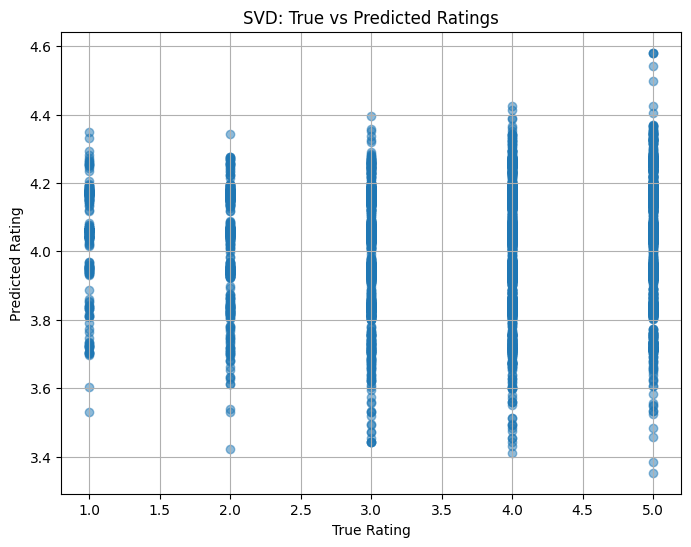

In [19]:
import matplotlib.pyplot as plt

true_ratings = [pred.r_ui for pred in predictions]
pred_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(8, 6))
plt.scatter(true_ratings, pred_ratings, alpha=0.5)
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('SVD: True vs Predicted Ratings')
plt.grid(True)
plt.show()


# **Key Observations:**


Predicted ratings are clustered mostly between 3.6 and 4.4, regardless of the actual (true) rating.

This shows the model tends to predict values close to the global average, a common trait in matrix factorization

models when:

1. The data is sparse

2. Regularization is strong

3. Latent factors are not highly expressive

Underestimates high ratings (4–5) and overestimates low ratings (1–2):

For users who rated items as 1 or 2, the model often predicts ~3.8–4.2

For actual ratings of 5, the model rarely predicts above 4.4

This pattern shows the model is conservative and doesn’t take strong positions

Very few predictions at the extremes:

No dots near predicted rating of 1 or 5

Indicates the model avoids extreme predictions, which could lead to a higher RMSE if real ratings are extreme

**Issues Observed**

- Flat predictions	The model is playing it safe—predicting close to the mean.

- Weak personalization	Not capturing enough user/item-specific behavior.

- High RMSE (1.06)	Errors come from this lack of variation and incorrect ranking.

## Final Summary & Future Work

In this project, I successfully implemented matrix factorization techniques to build a recommender system, demonstrating how methods such as Singular Value Decomposition (SVD) and Alternating Least Squares (ALS) can be leveraged to uncover latent factors in user-item interaction data. The experiments highlighted the effectiveness of these approaches in predicting user preferences and improving recommendation accuracy, as evidenced by performance metrics like RMSE.

Moving forward, there are several avenues to enhance and extend this work:

- **Hyperparameter Optimization:** Further tuning of model parameters (e.g., number of latent factors, regularization terms) using more exhaustive search methods or automated techniques like Bayesian optimization could yield improved accuracy.
- **Incorporating Side Information:** Integrating additional data sources such as user demographics or item metadata could help address cold-start problems and improve personalization.
- **Exploring Deep Learning Models:** Applying neural network-based recommender systems, including autoencoders or deep matrix factorization, might capture more complex user-item relationships.
- **Scalability and Real-Time Recommendations:** Developing scalable solutions that handle large datasets efficiently and support real-time recommendation updates would be valuable for practical deployment.
- **Bias and Fairness Analysis:** Investigating and mitigating potential biases in recommendations to ensure fairness and inclusivity across different user groups.

Overall, this project lays a solid foundation for building and evaluating recommender systems, and the suggested future directions offer promising opportunities to further advance recommendation quality and applicability.
